## Baseline Model for metadata + Images (KNN + Decision Tree)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

RandomState = 42

In [2]:
# load csv
data = pd.read_csv('../data/processed/Metadata_processed.csv')

In [3]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,dx_tertiary
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,non-neoplastic
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,non-neoplastic
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,non-neoplastic
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,non-neoplastic
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear,vidir_modern,not_skin_cancer,non-neoplastic


#### add image-path and image (as numpy array) as new column to metadata-table

In [4]:
import os
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier

# Define the path to our image directory
image_directory = './../data/jpgs/'  

# Function to generate image paths
def generate_image_path(image_id):
    return os.path.join(image_directory, str(image_id))

# Add image paths to the DataFrame
data['image_path'] = data['image_id'].apply(generate_image_path)

#use the path to read images
data['image'] = data['image_path'].map(lambda x: np.asarray(Image.open(x).resize((128,128))))


In [5]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,dx_tertiary,image_path,image
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0027419.jpg,"[[[189, 152, 194], [192, 156, 199], [191, 154,..."
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0025030.jpg,"[[[24, 13, 22], [24, 14, 22], [25, 14, 26], [2..."
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0026769.jpg,"[[[187, 127, 135], [190, 134, 146], [193, 136,..."
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0025661.jpg,"[[[24, 11, 17], [24, 11, 19], [29, 15, 25], [3..."
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0031633.jpg,"[[[129, 87, 109], [141, 96, 119], [151, 106, 1..."


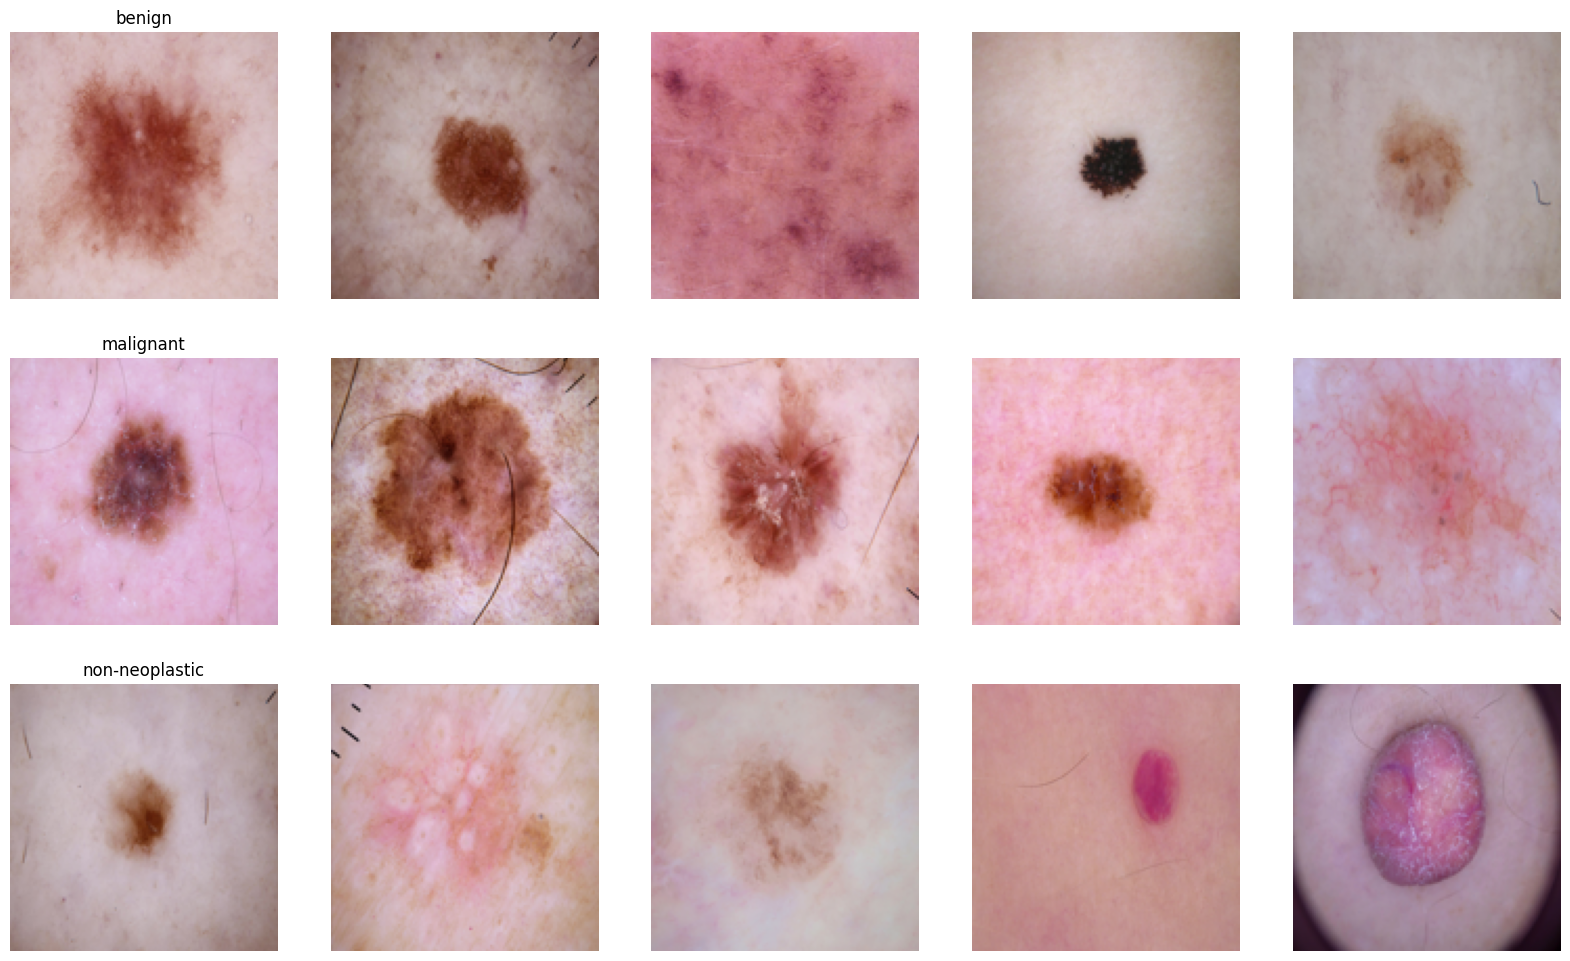

In [6]:
# plot the first 5 images in the dataset
n_samples = 5
fig, m_axs = plt.subplots(3, n_samples, figsize = (4*n_samples, 4*3))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         data.sort_values(['dx_tertiary']).groupby('dx_tertiary')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=34).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

### Assigning features and target + engineering

In [7]:
# covert X column into list
X = np.asarray(data['image'].tolist())
y = data['dx_tertiary']  

In [8]:
X.dtype

dtype('uint8')

In [9]:
# Scale X-values from 0-1 (minimum pixel value to maximum pixel value, which is in this case 255 because the images are 8-bit)
X = X/255

In [10]:
X.dtype

dtype('float64')

#### Flattening the images to a 2D array

In [11]:
# KNN only accepts 2d arrays, so we need to flatten the image arrays
X_flat = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])

#### convert y into binary, 1 for skin_cancer, 0 for not_skin_cancer

In [12]:
from sklearn import preprocessing

# convert y into binary, 0 for malignant, 1 for benign, 2 for non-neoplastic
le = preprocessing.LabelEncoder()
le.fit(["malignant", "benign", "non-neoplastic"])

# Transform the labels
y_encoded = le.transform(y)

# Now, y_encoded will have 0 for "not_skin_cancer" and 1 for "skin_cancer"
print(y_encoded)

[2 2 2 ... 1 1 1]


### Train Test Split



In [13]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_encoded, test_size=0.2, random_state=42)

### KNN

In [14]:
# function to print classification report and plot confusion matrix 
from sklearn.metrics import classification_report, confusion_matrix

def print_report(y_test, y_pred):
    print(classification_report(y_test, y_pred, digits=3))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 10})
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

              precision    recall  f1-score   support

           0      0.746     0.951     0.836      1338
           1      0.573     0.232     0.330       388
           2      0.468     0.235     0.312       277

    accuracy                          0.713      2003
   macro avg      0.596     0.473     0.493      2003
weighted avg      0.674     0.713     0.666      2003



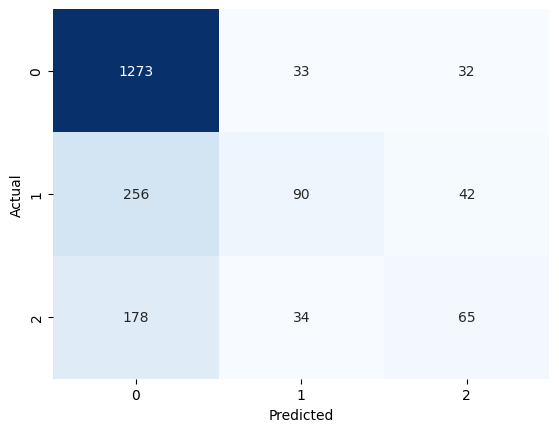

In [15]:
# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  

# Fit the classifier on the training data
knn_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_knn = knn_classifier.predict(X_test)

#report

print_report(y_test, y_pred_knn)


#### Hyperparameter Tuning KNN

In [16]:
#Hyperparameter tuning in KNNRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Create a dictionary of hyperparameters to search
grid_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

estimator = KNeighborsClassifier()

# Create a grid search object
gs_knn = RandomizedSearchCV(estimator,  grid_params,
    verbose=1,  cv=3,  n_jobs=-1 )

# Fit
gs_knn.fit(X_train, y_train)

# Get the best hyperparameters
print('Best hyperparameters:', gs_knn.best_params_)
print('Best score:', gs_knn.best_score_)
print('Best estimator:', gs_knn.best_estimator_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


Best hyperparameters: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'euclidean'}
Best score: 0.7185465005134447
Best estimator: KNeighborsClassifier(metric='euclidean', n_neighbors=7, weights='distance')


In [22]:
# fit knn model with best parameters
best_model_knn = gs_knn.best_estimator_

KNN Classifier after hyperparameter tuning:
              precision    recall  f1-score   support

           0      0.756     0.949     0.841      1338
           1      0.594     0.204     0.303       388
           2      0.444     0.303     0.361       277

    accuracy                          0.715      2003
   macro avg      0.598     0.485     0.502      2003
weighted avg      0.681     0.715     0.671      2003



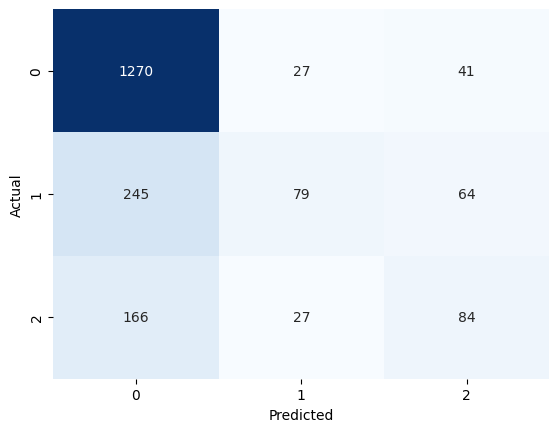

In [23]:
y_pred_knn_gs = best_model_knn.predict(X_test)

print('KNN Classifier after hyperparameter tuning:')
print_report(y_test, y_pred_knn_gs)


-------------------

### Decision Tree

              precision    recall  f1-score   support

           0      0.786     0.773     0.779      1338
           1      0.364     0.358     0.361       388
           2      0.282     0.310     0.296       277

    accuracy                          0.629      2003
   macro avg      0.477     0.481     0.479      2003
weighted avg      0.634     0.629     0.631      2003



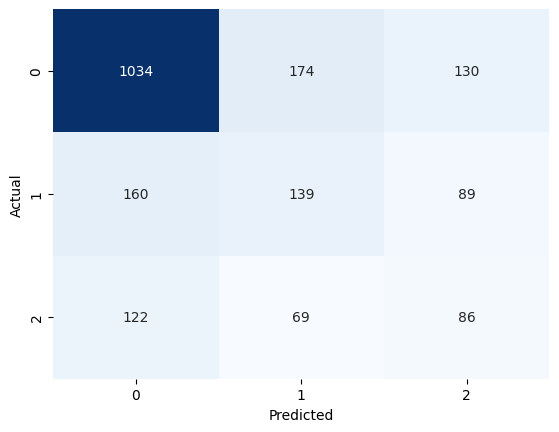

In [24]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the classifier on the training data
dt_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_dt = dt_classifier.predict(X_test)

# report
print_report(y_test, y_pred_dt)


#### Hyperparameter Tuning DT

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Create a dictionary of hyperparameters to search for DecisionTreeClassifier
grid_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

estimator = DecisionTreeClassifier()

# Create a grid search object
gs_dt = GridSearchCV(estimator, grid_params, verbose=1, cv=3, n_jobs=-1)

# Fit the grid search to your training data
gs_dt.fit(X_train, y_train)

# Get the best hyperparameters
print('Best hyperparameters:', gs_dt.best_params_)
print('Best score:', gs_dt.best_score_)
print('Best estimator:', gs_dt.best_estimator_)

In [ ]:
# fit DT model with best parameters
best_model_dt = gs_dt.best_estimator_
y_pred_dt_gs = best_model_dt.predict(X_test)

print('Decision Tree Classifier after hyperparameter tuning:')
print_report(y_test, y_pred_dt_gs)

#plot roc curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_dt_gs)

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve DT tuned')